# Importing the necessary libraries

In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

import tensorflow as tf 
from tensorflow.keras import layers , Model, Sequential



# Downloading the dataset

In [ ]:
!wget http://codingtest.fretello.com:3000/data/GuitarDatasetChallenge.zip

--2021-06-17 15:07:40--  http://codingtest.fretello.com:3000/data/GuitarDatasetChallenge.zip
Resolving codingtest.fretello.com (codingtest.fretello.com)... 85.31.0.230
Connecting to codingtest.fretello.com (codingtest.fretello.com)|85.31.0.230|:3000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5798625 (5.5M) [application/zip]
Saving to: ‘GuitarDatasetChallenge.zip’

GuitarDatasetChalle 100%[===================>]   5.53M  34.2KB/s    in 2m 40s  

2021-06-17 15:10:21 (35.3 KB/s) - ‘GuitarDatasetChallenge.zip’ saved [5798625/5798625]



In [ ]:
!unzip GuitarDatasetChallenge.zip

# Splitting the data to Train, Validation and Test sets

In [ ]:
!mkdir TRAIN TEST VAL TRAIN/ACOUSTIC TRAIN/ELECTRIC TEST/ACOUSTIC TEST/ELECTRIC VAL/ACOUSTIC VAL/ELECTRIC


In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'

In [ ]:
IMG_PATH = 'GuitarDatasetChallenge/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, TEST_DIR + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, TRAIN_DIR + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, VAL_DIR + CLASS.upper() + '/' + FILE_NAME)

# Loading and preprocessing the data 

In [ ]:
IMG_SIZE = (224,224)
RANDOM_SEED = 123

In [ ]:
def Dataset_loader(dir_path, RESIZE):
  IMG = []
  y = []
  i = 0
  labels = dict()

  read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

  for path in tqdm(sorted(os.listdir(dir_path))):
    if not path.startswith('_'):
      labels[i] = path
      for file in os.listdir(dir_path + path):
        if not file.startswith('.'):      
          img = read(dir_path + path + '/' + file)
          img = cv2.resize(img,RESIZE)
          IMG.append(np.array(img))
          y.append(i)
    i += 1

  return IMG, y, labels


In [ ]:
# use predefined function to load the image data into workspace
X_train, y_train, labels = Dataset_loader(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = Dataset_loader(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = Dataset_loader(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00, 33.00it/s]


## Data augmentation

### Demo

In [ ]:
demo_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
!mkdir preview


In [ ]:
x = X_train[40]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 10:
        break 

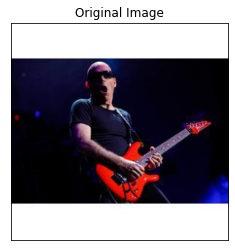

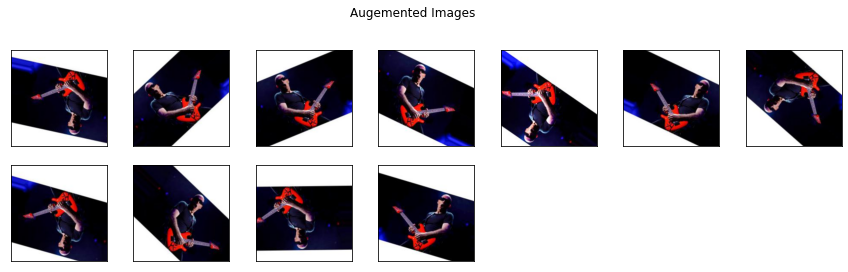

In [ ]:
plt.imshow(X_train[40])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

### Application

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=(0.75,1),
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 66 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


# Building the model

## Importing the pre-Trained Model VGG-16

### VGG-16 architecture:


* Input: Image of dimensions (224, 224, 3).

* Convolution Layer Conv1:
  * Conv1-1: 64 filters
  * Conv1-2: 64 filters and Max Pooling
  * Image dimensions: (224, 224)
* Convolution layer Conv2: Now, we increase the filters to 128
  * Input Image dimensions: (112,112)
  * Conv2-1: 128 filters
  * Conv2-2: 128 filters and Max Pooling
* Convolution Layer Conv3: Again, double the filters to 256, and now add another convolution layer
  * Input Image dimensions: (56,56)
  * Conv3-1: 256 filters
  * Conv3-2: 256 filters
  * Conv3-3: 256 filters and Max Pooling
* Convolution Layer Conv4: Similar to Conv3, but now with 512 filters
  * Input Image dimensions: (28, 28)
  * Conv4-1: 512 filters
  * Conv4-2: 512 filters
  * Conv4-3: 512 filters and Max Pooling
* Convolution Layer Conv5: Same as Conv4
  * Input Image dimensions: (14, 14)
  * Conv5-1: 512 filters
  * Conv5-2: 512 filters
  * Conv5-3: 512 filters and Max Pooling
  * The output dimensions here are (7, 7). At this point, we flatten the output of this layer to generate a feature vector

* 3  Fully Connected Layers

In [ ]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

# Compiling and training the final model

In [ ]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['acc']
)

In [ ]:
EPOCHS = 20
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/20
3/3 [==============================] - 1s 666ms/step - loss: 0.0894 - acc: 0.9697 - val_loss: 0.3617 - val_acc: 0.8947
Epoch 2/20
3/3 [==============================] - 1s 393ms/step - loss: 0.2583 - acc: 0.9848 - val_loss: 0.7021 - val_acc: 0.8947
Epoch 3/20
3/3 [==============================] - 1s 356ms/step - loss: 0.1369 - acc: 0.9394 - val_loss: 1.6402 - val_acc: 0.8421
Epoch 4/20
3/3 [==============================] - 1s 621ms/step - loss: 0.2295 - acc: 0.9848 - val_loss: 1.7386 - val_acc: 0.8421
Epoch 5/20
3/3 [==============================] - 1s 337ms/step - loss: 0.4594 - acc: 0.9545 - val_loss: 0.4622 - val_acc: 0.8947
Epoch 6/20
3/3 [==============================] - 1s 622ms/step - loss: 0.1459 - acc: 0.9848 - val_loss: 0.4783 - val_acc: 0.8947
Epoch 7/20
3/3 [==============================] - 1s 375ms/step - loss: 0.0591 - acc: 0.9697 - val_loss: 0.3713 - val_acc: 0.8947
Epoch 8/20
3/3 [==============================] - 1s 397ms/step - loss: 0.2786 - acc: 0.98

# plot model performance

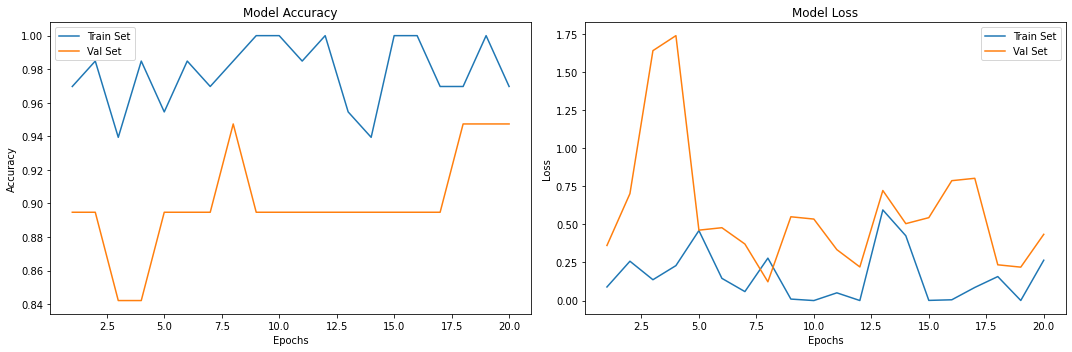

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Validation with the Test set

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Test Accuracy = 1.00


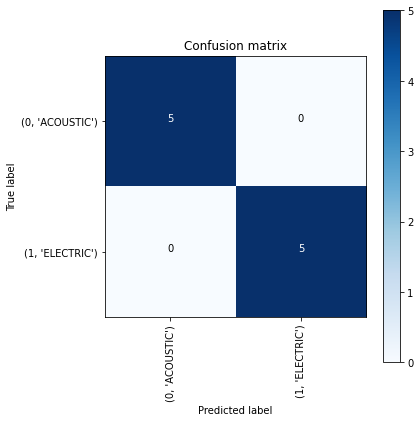

In [ ]:
# validate on test set
X_test = np.array(X_test)
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)